In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_csv('/home/suhas/Desktop/office/Data Science/Notes/Data Analysis/2024-Nov/Data/cars.csv')

In [25]:
df.head()

,brand,km_driven,fuel,owner,selling_price
0,Maruti,145500,Diesel,First Owner,450000
1,Skoda,120000,Diesel,Second Owner,370000
2,Honda,140000,Petrol,Third Owner,158000
3,Hyundai,127000,Diesel,First Owner,225000
4,Maruti,120000,Petrol,First Owner,130000


In [26]:
df.shape

(8128, 5)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   brand          8128 non-null   object
 1   km_driven      8128 non-null   int64 
 2   fuel           8128 non-null   object
 3   owner          8128 non-null   object
 4   selling_price  8128 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 317.6+ KB


In [28]:
df.isnull().sum()

brand            0
km_driven        0
fuel             0
owner            0
selling_price    0
dtype: int64

In [29]:
# List of brands to remove
brands_to_remove = ['Opel', 'Peugeot', 'Ashok']

# Keep only the rows where 'brand' is NOT in the list
df = df[~df['brand'].isin(brands_to_remove)]


In [30]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

X = df.drop(columns='selling_price')
y = df['selling_price']

In [31]:
X

,brand,km_driven,fuel,owner
0,Maruti,145500,Diesel,First Owner
1,Skoda,120000,Diesel,Second Owner
2,Honda,140000,Petrol,Third Owner
3,Hyundai,127000,Diesel,First Owner
4,Maruti,120000,Petrol,First Owner
...,...,...,...,...
8123,Hyundai,110000,Petrol,First Owner
8124,Hyundai,119000,Diesel,Fourth & Above Owner
8125,Maruti,120000,Diesel,First Owner
8126,Tata,25000,Diesel,First Owner


In [32]:
y

0       450000
1       370000
2       158000
3       225000
4       130000
         ...  
8123    320000
8124    135000
8125    382000
8126    290000
8127    290000
Name: selling_price, Length: 8125, dtype: int64

In [33]:
from sklearn.preprocessing import FunctionTransformer

label = FunctionTransformer(np.log1p)
y = label.fit_transform(y)

In [34]:
y

0       13.017005
1       12.821261
2       11.970357
3       12.323860
4       11.775297
          ...    
8123    12.676079
8124    11.813037
8125    12.853179
8126    12.577640
8127    12.577640
Name: selling_price, Length: 8125, dtype: float64

In [35]:
num_column = ['km_driven']
cat_column = ['brand', 'fuel', 'owner']

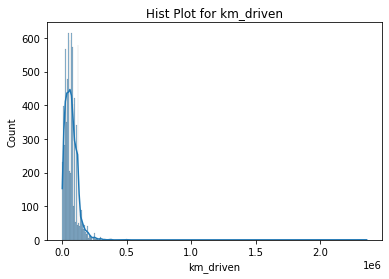

--------------------------------------------------


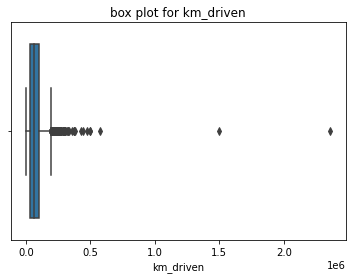

--------------------------------------------------


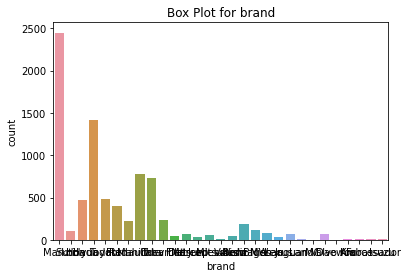

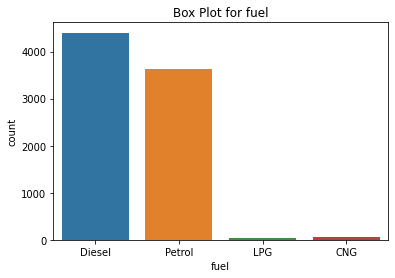

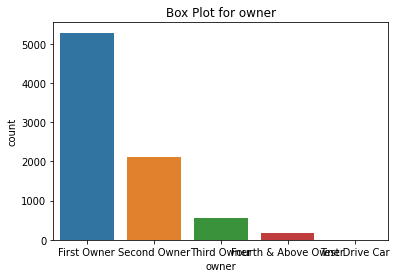

--------------------------------------------------


<AxesSubplot:xlabel='selling_price', ylabel='Count'>

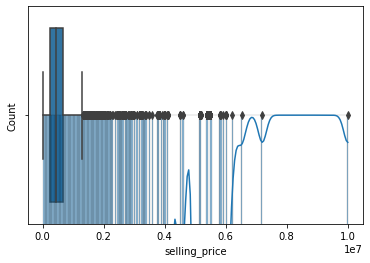

In [36]:
for col in num_column:
    sns.histplot(data=X,x=col,kde=True)
    plt.title(f"Hist Plot for {col}")
    plt.show()

print('-'*50)

for col in num_column:
    sns.boxplot(data=X,x=col)
    plt.title(f"box plot for {col}")
    plt.show()

print('-'*50)

for col in cat_column:
    sns.countplot(data=X,x=col)
    plt.title(f"Box Plot for {col}")
    plt.show()

print('-'*50)

sns.histplot(x=df['selling_price'],kde=True)
sns.boxplot(x=df['selling_price'])

## Feature Selection

In [37]:
# For numerical columns
from scipy.stats import spearmanr

significant_num_cols = {}
for col in num_column:
    corr,p_value = spearmanr(X[col],y)

    if p_value < 0.05:
        significant_num_cols[col] = {
        'corr':corr,
        'p_value': p_value
    }
        
    print(f"{col}:{corr:.3f},p_value:{p_value:.3f}")

print(significant_num_cols.keys())


km_driven:-0.355,p_value:0.000
dict_keys(['km_driven'])


In [38]:
# For categorical columns
from scipy.stats import kruskal

significant_cat_columns = {}

for col in cat_column:
    groups = [y[X[col]==cat] for cat in X[col].unique()]
    stat,p_value = kruskal(*groups)

    if p_value < 0.005:
        significant_cat_columns[col] = {
            'stat':stat,
            'p_value':p_value
        }
    print(f"{col}:{stat:.3f},p_value:{p_value:.3f}")

print(significant_cat_columns.keys())


brand:2244.910,p_value:0.000
fuel:938.949,p_value:0.000
owner:1422.522,p_value:0.000
dict_keys(['brand', 'fuel', 'owner'])


In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [40]:
X_train.shape

(6500, 4)

In [41]:
X_train.columns

Index(['brand', 'km_driven', 'fuel', 'owner'], dtype='object')

In [42]:
from sklearn.preprocessing import RobustScaler,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


num_pipe = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('scalar',StandardScaler()),
    
])

cat_pipe = Pipeline([
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',sparse=False)),
    
])

preprocess_cols = ColumnTransformer([
    ('num_pre',num_pipe,num_column),
    ('cat_pre',cat_pipe,cat_column)
])


In [43]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import joblib
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

algorithms = {
    'random_forest': RandomForestRegressor(),
    'adb': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'dt': DecisionTreeRegressor(),
    'svr': SVR(),
    'lr': LinearRegression(),
    'knn': KNeighborsRegressor(),
    'xgb': xgb.XGBRegressor()

}


for name,algo in algorithms.items():
    model = Pipeline([
        ('preprocess',preprocess_cols),
        ('algo',algo)
    ])

    model.fit(X_train,y_train)

    joblib.dump(model,f"{name}.pkl")

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    cs_score = cross_val_score(model,X,y,scoring='r2',cv=5)
    cv_mean = cs_score.mean()

    print(f"{name}")
    print(f"R2:{r2}")
    print(f"MSE:{mse}")
    print(f"MAE:{mae}")
    print(f"CV score:{cs_score}")
    print(f"CV Mean:{cv_mean}")
    print('-'*50)

    

random_forest
R2:0.6378471048055114
MSE:0.25380968181243513
MAE:0.36231968137615767
CV score:[0.63142138 0.64115096 0.6374333  0.59537507 0.62489409]
CV Mean:0.6260549601132416
--------------------------------------------------
adb
R2:0.39480053067408327
MSE:0.42414540041209414
MAE:0.5219419673375316
CV score:[0.38916272 0.38047088 0.42642006 0.40474    0.37904091]
CV Mean:0.39596691430500786
--------------------------------------------------
gb
R2:0.6698394228924092
MSE:0.2313883228178673
MAE:0.3690048556320362
CV score:[0.66878985 0.65327867 0.67607885 0.64245389 0.66017015]
CV Mean:0.6601542833454012
--------------------------------------------------
dt
R2:0.5770032943592998
MSE:0.2964511969694955
MAE:0.3791173867161191
CV score:[0.58984631 0.54376226 0.58589585 0.52004162 0.55527479]
CV Mean:0.5589641652248749
--------------------------------------------------
svr
R2:0.6873528211865808
MSE:0.21911430787147015
MAE:0.34873418258629313
CV score:[0.67396331 0.6572796  0.68344719 0.6431